In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import math
import os
from sklearn.preprocessing import scale
from tensorflow.keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dropout, Flatten, Dense, BatchNormalization, Attention
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dropout, BatchNormalization, Flatten, Dense, Attention
from tensorflow.keras.models import Model
# Function to map categorical probabilities to class labels
def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

# Function to calculate performance metrics
def calculate_performance(test_num, pred_y, labels):
    tp, fp, tn, fn = 0, 0, 0, 0
    for index in range(test_num):
        if labels[index] == 1:
            if labels[index] == pred_y[index]:
                tp += 1
            else:
                fn += 1
        else:
            if labels[index] == pred_y[index]:
                tn += 1
            else:
                fp += 1

    acc = (tp + tn) / test_num
    precision = tp / (tp + fp + 1e-6)
    npv = tn / (tn + fn + 1e-6)
    sensitivity = tp / (tp + fn + 1e-6)
    specificity = tn / (tn + fp + 1e-6)
    mcc = (tp * tn - fp * fn) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-6)
    f1 = 2 * tp / (2 * tp + fp + fn + 1e-6)
    return acc, precision, npv, sensitivity, specificity, mcc, f1, tp, tn, fp, fn

# Function to define and return the CNN-BiLSTM model
def get_CNN_model_with_attention(input_dim, out_dim):
    # Define the input
    inputs = Input(shape=(1, input_dim))

    # LSTM layers
    lstm_1 = LSTM(int(input_dim/2), return_sequences=True)(inputs)
    dropout_1 = Dropout(0.7)(lstm_1)
    batchnorm_1 = BatchNormalization()(dropout_1)

    lstm_2 = LSTM(int(input_dim/4), return_sequences=True)(batchnorm_1)
    dropout_2 = Dropout(0.7)(lstm_2)
    batchnorm_2 = BatchNormalization()(dropout_2)

    lstm_3 = LSTM(int(input_dim/8), return_sequences=False)(batchnorm_2)
    dropout_3 = Dropout(0.7)(lstm_3)

    # Attention mechanism (modified to use functional API)
    attention = Attention()([dropout_3, dropout_3])  

    # Fully connected layers
    flatten = Flatten()(attention)
    dense_1 = Dense(int(input_dim/4), activation='relu')(flatten)
    dense_2 = Dense(int(input_dim/8), activation='relu')(dense_1)
    output = Dense(out_dim, activation='softmax', name="Dense_2")(dense_2)

    # Define the model
    model = Model(inputs=inputs, outputs=output)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
    
    return model

# Folder containing CSV files
input_dir = './cla06/'
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

# Loop through each CSV file
for file_name in csv_files:
    base_name = os.path.splitext(file_name)[0]
    output_base_dir = f"./2024LSTM_{file_name}/"
    os.makedirs(output_base_dir, exist_ok=True)

    # Load data
    data_ = pd.read_csv(os.path.join(input_dir, file_name))

    data = data_.iloc[:, 1:]
    data = data.loc[0:1081]
    
    ones_vector1 = np.ones(480)
    zeros_vector1 = np.zeros(602)
    y = np.hstack((ones_vector1, zeros_vector1))

    X = scale(data)

    sepscores = []
    ytest = np.ones((1, 2)) * 0.5
    yscore = np.ones((1, 2)) * 0.5

    [sample_num, input_dim] = np.shape(X)
    out_dim = 2

    probas_cnn = []
    tprs_cnn = []
    sepscore_cnn = []

    # Callbacks for model training
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    call = [EarlyStopping(monitor='val_loss', patience=25), reduce_lr]

    # 10-fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for i, (train, test) in enumerate(skf.split(X, y)):
        #clf_cnn = get_CNN_model(input_dim, out_dim)
        clf_cnn = get_CNN_model_with_attention(input_dim, out_dim)
        X_train_cnn = np.reshape(X[train], (-1, 1, input_dim))
        X_test_cnn = np.reshape(X[test], (-1, 1, input_dim))
        y_test = to_categorical(y[test])
        ytest = np.vstack((ytest, y_test))
        y_test_tmp = y[test]

        # Training
        history = clf_cnn.fit(X_train_cnn, to_categorical(y[train]), validation_data=(X_test_cnn, y_test),
                              batch_size=8, epochs=50, callbacks=call)

        # Prediction
        y_cnn_probas = clf_cnn.predict(X_test_cnn)
        probas_cnn.append(y_cnn_probas)
        y_class = np.argmax(y_cnn_probas, axis=1)
        yscore = np.vstack((yscore, y_cnn_probas))

        # Calculate performance metrics
        acc, precision, npv, sensitivity, specificity, mcc, f1, tp, tn, fp, fn = calculate_performance(len(y_class), y_class, y[test])
        fpr, tpr, thresholds = roc_curve(y[test], y_cnn_probas[:, 1])
        roc_auc = auc(fpr, tpr)
        sepscore_cnn.append([acc, precision, npv, sensitivity, specificity, mcc, f1, roc_auc, tp, tn, fp, fn])
        print(f'{i} CNN: acc={acc:.6f}, precision={precision:.6f}, npv={npv:.6f}, sensitivity={sensitivity:.6f}, '
              f'specificity={specificity:.6f}, mcc={mcc:.6f}, f1={f1:.6f}, roc_auc={roc_auc:.6f}')

        # Save the model
        model_json = clf_cnn.to_json()
        with open(f"{output_base_dir}/CNN_BiLSTM_{str(i)}model.json", "w") as json_file:
            json_file.write(model_json)
        clf_cnn.save_weights(f"{output_base_dir}/CNN_BiLSTM_{str(i)}model.weights.h5")
        print("Saved model to disk")

    # Save ytest and yscore to CSV
    row = ytest.shape[0]
    ytest = ytest[np.array(range(1, row)), :]
    ytest_sum = pd.DataFrame(data=ytest)
    ytest_sum.to_csv(f'{output_base_dir}/ytest.csv')

    yscore_ = yscore[np.array(range(1, row)), :]
    yscore_sum = pd.DataFrame(data=yscore_)
    yscore_sum.to_csv(f'{output_base_dir}/yscore.csv')

    # Save results of cross-validation
    scores = np.array(sepscore_cnn)
    result1 = np.mean(scores, axis=0)
    H1 = result1.tolist()
    sepscore_cnn.append(H1)
    result = sepscore_cnn
    data_csv = pd.DataFrame(data=result, columns=['acc', 'precision', 'npv', 'sensitivity', 'specificity', 'mcc', 'f1', 'roc_auc', 'tp', 'tn', 'fp', 'fn'])
    data_csv.to_csv(f'{output_base_dir}/results_CV.csv', index=False)

    print(history)

    # Testing phase with another part of data
    test_data = data_.iloc[:, 1:]
    test_data = test_data.loc[1082:]

    ones_vector = np.ones(69)
    zeros_vector = np.zeros(110)
    yt = np.hstack((ones_vector, zeros_vector))

    Xt = scale(test_data)
    Xt = np.reshape(Xt, (-1, 1, input_dim))

    sepscores = []
    ytest = np.ones((1, 2)) * 0.5
    yscore = np.ones((1, 2)) * 0.5

    # Load and test saved models
    for i in range(10):
        with open(f"{output_base_dir}CNN_BiLSTM_{str(i)}model.json", 'r') as json_file:
            loaded_model_json = json_file.read()

        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(f"{output_base_dir}CNN_BiLSTM_{i}model.weights.h5")
        print("Loaded model from disk")

        loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        y_score = loaded_model.predict(Xt)
        y_class = categorical_probas_to_classes(y_score)

        y_test = to_categorical(yt)
        acc, precision, npv, sensitivity, specificity, mcc, f1, tp, tn, fp, fn = calculate_performance(len(y_class), y_class, yt)
        fpr, tpr, thresholds = roc_curve(yt, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        sepscores.append([acc, precision, npv, sensitivity, specificity, mcc, f1, roc_auc, tp, tn, fp, fn])
        print(f'{i} CNN Test: acc={acc:.6f}, precision={precision:.6f}, npv={npv:.6f}, sensitivity={sensitivity:.6f}, '
              f'specificity={specificity:.6f}, mcc={mcc:.6f}, f1={f1:.6f}, roc_auc={roc_auc:.6f}')

        # Save prediction results
        ytest = np.vstack((ytest, y_test))
        yscore = np.vstack((yscore, y_score))

    # Save testing results
    row = ytest.shape[0]
    ytest = ytest[np.array(range(1, row)), :]
    ytest_sum = pd.DataFrame(data=ytest)
    ytest_sum.to_csv(f'{output_base_dir}/ytest_test.csv')

    yscore_ = yscore[np.array(range(1, row)), :]
    yscore_sum = pd.DataFrame(data=yscore_)
    yscore_sum.to_csv(f'{output_base_dir}/yscore_test.csv')

    # Save testing results of cross-validation
    scores = np.array(sepscores)
    result1 = np.mean(scores, axis=0)
    H1 = result1.tolist()
    sepscores.append(H1)
    result = sepscores
    data_csv = pd.DataFrame(data=result, columns=['acc', 'precision', 'npv', 'sensitivity', 'specificity', 'mcc', 'f1', 'roc_auc', 'tp', 'tn', 'fp', 'fn'])
    data_csv.to_csv(f'{output_base_dir}/results_test.csv', index=False)


Epoch 1/50
122/122 [==============================] - 17s 40ms/step - loss: 0.6861 - accuracy: 0.5478 - val_loss: 0.6850 - val_accuracy: 0.5596 - lr: 5.0000e-04
Epoch 2/50
122/122 [==============================] - 3s 25ms/step - loss: 0.6814 - accuracy: 0.5581 - val_loss: 0.6577 - val_accuracy: 0.7064 - lr: 5.0000e-04
Epoch 3/50
122/122 [==============================] - 2s 20ms/step - loss: 0.6708 - accuracy: 0.5755 - val_loss: 0.5735 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 4/50
122/122 [==============================] - 2s 18ms/step - loss: 0.6325 - accuracy: 0.6413 - val_loss: 0.3601 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 5/50
122/122 [==============================] - 2s 15ms/step - loss: 0.5714 - accuracy: 0.7050 - val_loss: 0.2093 - val_accuracy: 0.9908 - lr: 5.0000e-04
Epoch 6/50
122/122 [==============================] - 2s 16ms/step - loss: 0.5509 - accuracy: 0.7256 - val_loss: 0.1903 - val_accuracy: 0.9908 - lr: 5.0000e-04
Epoch 7/50
122/122 [===================

In [ ]:
# Recheck mcc, auc_roc

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
import math
import os
from sklearn.preprocessing import scale
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold


# Function to map categorical probabilities to class labels
def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)


# Function to calculate performance metrics
def calculate_performance(test_num, pred_y, labels):
    tp, fp, tn, fn = 0, 0, 0, 0
    for index in range(test_num):
        if labels[index] == 1:
            if labels[index] == pred_y[index]:
                tp += 1
            else:
                fn += 1
        else:
            if labels[index] == pred_y[index]:
                tn += 1
            else:
                fp += 1

    acc = (tp + tn) / test_num
    precision = tp / (tp + fp + 1e-6)
    npv = tn / (tn + fn + 1e-6)
    sensitivity = tp / (tp + fn + 1e-6)
    specificity = tn / (tn + fp + 1e-6)
    mcc = (tp * tn - fp * fn) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-6)
    f1 = 2 * tp / (2 * tp + fp + fn + 1e-6)
    return acc, precision, npv, sensitivity, specificity, mcc, f1, tp, tn, fp, fn


# Function to define and return the CNN-BiLSTM model
def get_CNN_model(input_dim, out_dim):
    model = Sequential()
    model.add(Bidirectional(LSTM(int(input_dim / 4), return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(int(input_dim / 8), return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(int(input_dim / 4), activation='relu'))
    model.add(Dense(int(input_dim / 8), activation='relu'))
    model.add(Dense(out_dim, activation='softmax', name="Dense_2"))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model


# Folder containing CSV files
input_dir = './New_feature_2/'
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

# Loop through each CSV file
for file_name in csv_files:
    base_name = os.path.splitext(file_name)[0]
    output_base_dir = f"./Elasfull_EN_LSTM_{file_name}/"
    os.makedirs(output_base_dir, exist_ok=True)

    # Load data
    data_ = pd.read_csv(os.path.join(input_dir, file_name))
    data = data_.iloc[:, 1:]
    data = data.loc[0:1081]

    ones_vector1 = np.ones(480)
    zeros_vector1 = np.zeros(602)
    y = np.hstack((ones_vector1, zeros_vector1))

    X = scale(data)

    sepscores_cnn = []
    ytest = np.ones((1, 2)) * 0.5
    yscore = np.ones((1, 2)) * 0.5

    [sample_num, input_dim] = np.shape(X)
    out_dim = 2

    # Callbacks for model training
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    call = [EarlyStopping(monitor='val_loss', patience=25), reduce_lr]

    # 10-fold cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for i, (train, test) in enumerate(skf.split(X, y)):
        clf_cnn = get_CNN_model(input_dim, out_dim)
        X_train_cnn = np.reshape(X[train], (-1, 1, input_dim))
        X_test_cnn = np.reshape(X[test], (-1, 1, input_dim))
        y_test = to_categorical(y[test])
        ytest = np.vstack((ytest, y_test))
        y_test_tmp = y[test]

        # Training
        history = clf_cnn.fit(X_train_cnn, to_categorical(y[train]), validation_data=(X_test_cnn, y_test),
                              batch_size=8, epochs=50, callbacks=call)

        # Prediction
        y_cnn_probas = clf_cnn.predict(X_test_cnn)
        yscore = np.vstack((yscore, y_cnn_probas))
        y_class = np.argmax(y_cnn_probas, axis=1)

        # Calculate performance metrics
        acc, precision, npv, sensitivity, specificity, mcc, f1, tp, tn, fp, fn = calculate_performance(len(y_class), y_class, y[test])
        fpr, tpr, thresholds = roc_curve(y[test], y_cnn_probas[:, 1])
        roc_auc = auc(fpr, tpr)
        sepscores_cnn.append([acc, precision, npv, sensitivity, specificity, mcc, f1, roc_auc, tp, tn, fp, fn])
        print(f'{i} CNN CV: acc={acc:.6f}, precision={precision:.6f}, npv={npv:.6f}, sensitivity={sensitivity:.6f}, '
              f'specificity={specificity:.6f}, mcc={mcc:.6f}, f1={f1:.6f}, roc_auc={roc_auc:.6f}')

        # Save the model
        model_json = clf_cnn.to_json()
        with open(f"{output_base_dir}/CNN_BiLSTM_{str(i)}model.json", "w") as json_file:
            json_file.write(model_json)
        clf_cnn.save_weights(f"{output_base_dir}/CNN_BiLSTM_{str(i)}model.weights.h5")
        print("Saved model to disk")

    # Save cross-validation results
    scores = np.array(sepscores_cnn)
    result1 = np.mean(scores, axis=0)
    H1 = result1.tolist()
    sepscores_cnn.append(H1)
    result = sepscores_cnn
    data_csv = pd.DataFrame(data=result, columns=['acc', 'precision', 'npv', 'sensitivity', 'specificity', 'mcc', 'f1', 'roc_auc', 'tp', 'tn', 'fp', 'fn'])
    data_csv.to_csv(f'{output_base_dir}/results_CV.csv', index=False)

    # Independent test
    test_data = data_.iloc[:, 1:]
    test_data = test_data.loc[1082:]
    ones_vector = np.ones(69)
    zeros_vector = np.zeros(110)
    yt = np.hstack((ones_vector, zeros_vector))

    Xt = scale(test_data)
    Xt = np.reshape(Xt, (-1, 1, input_dim))

    sepscores_ind = []

    for i in range(10):
        with open(f"{output_base_dir}/CNN_BiLSTM_{i}model.json", 'r') as json_file:
            loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(f"{output_base_dir}/CNN_BiLSTM_{i}model.weights.h5")
        print("Loaded model from disk")

        loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        y_score = loaded_model.predict(Xt)
        y_class = categorical_probas_to_classes(y_score)

        acc, precision, npv, sensitivity, specificity, mcc, f1, tp, tn, fp, fn = calculate_performance(len(y_class), y_class, yt)
        fpr, tpr, thresholds = roc_curve(yt, y_score[:, 1])
        roc_auc = auc(fpr, tpr)
        sepscores_ind.append([acc, precision, npv, sensitivity, specificity, mcc, f1, roc_auc, tp, tn, fp, fn])
        print(f'{i} CNN Test: acc={acc:.6f}, precision={precision:.6f}, npv={npv:.6f}, sensitivity={sensitivity:.6f}, '
              f'specificity={specificity:.6f}, mcc={mcc:.6f}, f1={f1:.6f}, roc_auc={roc_auc:.6f}')

    # Save independent test results
    scores = np.array(sepscores_ind)
    result = pd.DataFrame(data=scores, columns=['acc', 'precision', 'npv', 'sensitivity', 'specificity', 'mcc', 'f1', 'roc_auc', 'tp', 'tn', 'fp', 'fn'])
    result.to_csv(f'{output_base_dir}/results_Independent.csv', index=False)


Epoch 1/50
122/122 [==============================] - 20s 24ms/step - loss: 0.4548 - accuracy: 0.7688 - val_loss: 0.3848 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 2/50
122/122 [==============================] - 1s 11ms/step - loss: 0.1673 - accuracy: 0.9476 - val_loss: 0.4357 - val_accuracy: 0.8165 - lr: 0.0010
Epoch 3/50
122/122 [==============================] - 1s 10ms/step - loss: 0.1117 - accuracy: 0.9651 - val_loss: 0.4398 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 4/50
122/122 [==============================] - 1s 10ms/step - loss: 0.0889 - accuracy: 0.9671 - val_loss: 0.3967 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 5/50
122/122 [==============================] - 1s 10ms/step - loss: 0.0790 - accuracy: 0.9753 - val_loss: 0.3936 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 6/50
122/122 [==============================] - 1s 10ms/step - loss: 0.0582 - accuracy: 0.9805 - val_loss: 0.4079 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 7/50
122/122 [==============================] - 1s 9ms/st

In [1]:
from keras.models import model_from_json

# Load the model architecture
with open("cla06_elas_new_2/CNN_BiLSTM_1model.json", "r") as json_file:
    model_json = json_file.read()

# Reconstruct the model from the JSON file
model = model_from_json(model_json)

# Load the model weights
model.load_weights("cla06_elas_new_2/CNN_BiLSTM_1model.weights.h5")

# Display the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 387)]             0         []                            
                                                                                                  
 lstm_33 (LSTM)              (None, 1, 193)               448532    ['input_2[0][0]']             
                                                                                                  
 dropout_33 (Dropout)        (None, 1, 193)               0         ['lstm_33[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 1, 193)               772       ['dropout_33[0][0]']          
 tchNormalization)                                                                          

In [15]:
from keras.models import model_from_json

# Load the model architecture
with open("cla06_elas_new_2/CNN_BiLSTM_1model.json", "r") as json_file:
    model_json = json_file.read()

# Reconstruct the model from the JSON file
model = model_from_json(model_json)

# Load the model weights
model.load_weights("cla06_elas_new_2/CNN_BiLSTM_1model.weights.h5")

# Change layer names
for layer in model.layers:
    if 'input' in layer.name.lower():
        layer._name = 'Input'
    elif 'lstm' in layer.name.lower():
        layer._name = 'LSTM'
    elif 'dense' in layer.name.lower():
        layer._name = layer.name.lower()  # Convert 'Dense' to 'dense'
        layer._name = 'dense'
    elif 'dropout' in layer.name.lower():
        layer._name = 'dropout'
    elif 'batch_normalization' in layer.name.lower():
        layer._name = 'batch_normalization'
    elif 'attention' in layer.name.lower():
        layer._name = 'attention'
    elif 'flatten' in layer.name.lower():
        layer._name = 'flatten'

# Display the model summary with the new names
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 1, 387)]             0         []                            
                                                                                                  
 LSTM (LSTM)                 (None, 1, 193)               448532    ['Input[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 1, 193)               0         ['LSTM[0][0]']                
                                                                                                  
 batch_normalization (Batch  (None, 1, 193)               772       ['dropout[0][0]']             
 Normalization)                                                                             

In [2]:
!pip install pydot pydotplus graphviz



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "c:\users\user\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "c:\users\user\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "c:\users\user\anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "c:\users\user\anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 483, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "c:\users\user\anaconda3\lib\site-packages\pip\_internal\metadata\pkg_resources.py", line 192, in version
    return parse_version(self._dist.version)
  File "c:\users\user\anaconda3\lib\site-packages\pip\_vendor\


  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLayer (InputLayer)     [(None, 1, 387)]             0         []                            
                                                                                                  
 BiLSTM (LSTM)               (None, 1, 193)               448532    ['InputLayer[0][0]']          
                                                                                                  
 DropoutLayer (Dropout)      (None, 1, 193)               0         ['BiLSTM[0][0]']              
                                                                                                  
 BatchNorm (BatchNormalizat  (None, 1, 193)               772       ['DropoutLayer[0][0]']        
 ion)                                                                                       

ValueError: The target structure is of type `<class 'keras.src.engine.keras_tensor.KerasTensor'>`
  KerasTensor(type_spec=TensorSpec(shape=(None, 1, 387), dtype=tf.float32, name='input_2'), name='inpu...
However the input is a sequence (<class 'list'>) of length 0.
  []
nest cannot guarantee that it is safe to map one to the other.

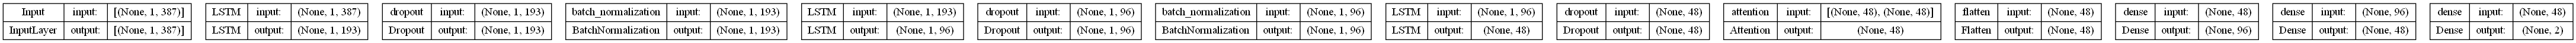

In [14]:
from keras.utils import plot_model

# เซฟรูปโครงสร้างโมเดลใหม่ พร้อมกับการจัดแสดงรูปแบบที่เหมาะสม
plot_model(model, to_file='model_architecture_rename.png', show_shapes=True, show_layer_names=True, rankdir='TB')
